#  Food-101 Challenge

##### By: Thomas Butterfield

### Import Modules

In [1]:
import os
import glob
import zipfile
import functools
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
# mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.initializers import glorot_uniform

from tensorflow.contrib.slim.python.slim.nets.resnet_utils import *

from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.utils.np_utils import to_categorical


## Data Reading, Preperation and Visualisation

### Data Reading

In [2]:
# Directory path of food 101 data set
food101_dir = '/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/'

In [3]:
# Reads train/test data into a pandas dataframe
Test_Image_Label_df = pd.read_json(food101_dir+'meta/test.json')
Train_Image_Label_df = pd.read_json(food101_dir+'meta/train.json')

In [4]:
# Displays the first few rows of the dataframe
Test_Image_Label_df.head()

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,...,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1061830,hot_and_sour_soup/1000486,samosa/1009326,sashimi/100113,pork_chop/1012227,spring_rolls/1005480,panna_cotta/1006650,beef_tartare/101073,greek_salad/1010850,foie_gras/1007306,...,chicken_quesadilla/10257,pho/1002382,prime_rib/1006976,cheesecake/1023543,ice_cream/1004744,omelette/1019294,grilled_cheese_sandwich/1000938,lobster_roll_sandwich/1002698,nachos/1011831,oysters/1005672
1,churros/1064042,hot_and_sour_soup/1004564,samosa/1024186,sashimi/1017182,pork_chop/1019077,spring_rolls/103010,panna_cotta/1027460,beef_tartare/1029120,greek_salad/1029680,foie_gras/1044237,...,chicken_quesadilla/1030292,pho/1020153,prime_rib/102197,cheesecake/102854,ice_cream/1031536,omelette/1058816,grilled_cheese_sandwich/1003050,lobster_roll_sandwich/1029665,nachos/101954,oysters/1017801
2,churros/1074903,hot_and_sour_soup/1011278,samosa/1036216,sashimi/1043094,pork_chop/102958,spring_rolls/1036175,panna_cotta/1030883,beef_tartare/1030025,greek_salad/1053670,foie_gras/1073688,...,chicken_quesadilla/1052529,pho/1026354,prime_rib/102813,cheesecake/1073148,ice_cream/1075106,omelette/1116874,grilled_cheese_sandwich/1005927,lobster_roll_sandwich/103891,nachos/103312,oysters/1019666
3,churros/1085259,hot_and_sour_soup/1029400,samosa/103689,sashimi/1050391,pork_chop/1040432,spring_rolls/1044858,panna_cotta/103712,beef_tartare/1031053,greek_salad/1062715,foie_gras/1113614,...,chicken_quesadilla/1096804,pho/1028507,prime_rib/1035695,cheesecake/1092082,ice_cream/1100243,omelette/1122818,grilled_cheese_sandwich/100694,lobster_roll_sandwich/104300,nachos/1044020,oysters/1040557
4,churros/1097261,hot_and_sour_soup/1044215,samosa/1052427,sashimi/10551,pork_chop/1045605,spring_rolls/1067952,panna_cotta/1050629,beef_tartare/1066933,greek_salad/1101710,foie_gras/1125178,...,chicken_quesadilla/1102036,pho/1029709,prime_rib/105375,cheesecake/1096018,ice_cream/1106165,omelette/1145379,grilled_cheese_sandwich/1052563,lobster_roll_sandwich/1046809,nachos/1060157,oysters/1044823


In [5]:
Train_Image_Label_df.head()

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,...,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1004234,hot_and_sour_soup/1002782,samosa/1008131,sashimi/1001239,pork_chop/1000802,spring_rolls/1002160,panna_cotta/1001332,beef_tartare/1000431,greek_salad/1007149,foie_gras/1004944,...,chicken_quesadilla/1004279,pho/1005681,prime_rib/1001089,cheesecake/1001446,ice_cream/1012277,omelette/1001719,grilled_cheese_sandwich/1003153,lobster_roll_sandwich/100009,nachos/100284,oysters/1008124
1,churros/1013460,hot_and_sour_soup/1003688,samosa/1011601,sashimi/1001363,pork_chop/1006233,spring_rolls/1003056,panna_cotta/1003460,beef_tartare/1005746,greek_salad/1009138,foie_gras/1008577,...,chicken_quesadilla/1009225,pho/1011443,prime_rib/1006320,cheesecake/1004515,ice_cream/101858,omelette/1007843,grilled_cheese_sandwich/10060,lobster_roll_sandwich/1001432,nachos/1009513,oysters/1016229
2,churros/1016791,hot_and_sour_soup/1008185,samosa/101365,sashimi/1002556,pork_chop/1019530,spring_rolls/1003507,panna_cotta/1011097,beef_tartare/1009672,greek_salad/1010520,foie_gras/1011711,...,chicken_quesadilla/1011413,pho/1012513,prime_rib/100945,cheesecake/1004807,ice_cream/102595,omelette/1015300,grilled_cheese_sandwich/1007544,lobster_roll_sandwich/100646,nachos/1011394,oysters/1023832
3,churros/102100,hot_and_sour_soup/1008701,samosa/1015943,sashimi/1007253,pork_chop/1019569,spring_rolls/1008736,panna_cotta/1013000,beef_tartare/1012128,greek_salad/1011665,foie_gras/1017233,...,chicken_quesadilla/1023828,pho/1019401,prime_rib/10120,cheesecake/1017408,ice_cream/1044117,omelette/1029915,grilled_cheese_sandwich/1013343,lobster_roll_sandwich/100655,nachos/1013641,oysters/103236
4,churros/1025494,hot_and_sour_soup/1008924,samosa/1016296,sashimi/1010510,pork_chop/1025391,spring_rolls/1012525,panna_cotta/1020036,beef_tartare/1027680,greek_salad/1012989,foie_gras/1023512,...,chicken_quesadilla/1024740,pho/1021371,prime_rib/1016126,cheesecake/1021942,ice_cream/104465,omelette/1038109,grilled_cheese_sandwich/1016030,lobster_roll_sandwich/100702,nachos/1014846,oysters/1038150


In [6]:
# Directory path of the food 101 image library
Images_dir = food101_dir+'images/'

In [7]:
# Initialises a list in order to concatenate two pandas data frames
LCM = []
# Reads Labels/Classes data into seperate pandas dataframes
Labels_df = pd.read_csv(food101_dir+'meta/labels.txt', index_col = None, header = None, names = ['Labels'])
Classes_df = pd.read_csv(food101_dir+'meta/classes.txt', index_col = None, header = None, names = ['Classes'])

# Appends dataframes to list (LCM)
LCM.append(Labels_df)
LCM.append(Classes_df)
# Concatenates separate dataframes into a single dataframe mapping Labels to Classes with indexes
Labels_Classes_Mapping = pd.concat(LCM, axis=1)
# Displays first few rows of the dataframe
Labels_Classes_Mapping.head()

,Labels,Classes
0,Apple pie,apple_pie
1,Baby back ribs,baby_back_ribs
2,Baklava,baklava
3,Beef carpaccio,beef_carpaccio
4,Beef tartare,beef_tartare


### Data Preperation

In [8]:
# Initialises train/test/validation dictionary datasets 
# that will map the file path of image (key) to the Label index of the image (value)
Test_Image_ds = {}
Train_Image_ds = {}
Valid_Image_ds = {}

# For loop algorithm that iterates over column heading i (Classes) of the train/test dataframes 
# and then maps Class to the right Label index using the Labels/Class Mapping dataframe
for i in Test_Image_Label_df:
    index = 0
    for b in Labels_Classes_Mapping['Classes']:
        if i == b:
            Label = index
            break
        
        index += 1
        
# With the Label index determined, for every element a (images) under the Class i column heading,
# create an entry into the dictionary with the full path of image (key) along with its Label index (value)
    for a in Test_Image_Label_df[i]:
        Test_Image_ds[Images_dir+a+'.jpg'] = Label

# Repeat same process for Train dataframe
for i in Train_Image_Label_df:
    index = 0
    for b in Labels_Classes_Mapping['Classes']:
        if i == b:
            Label = index
            index = 0
            break
        
        index += 1
    
    for a in Train_Image_Label_df[i]:
        Train_Image_ds[Images_dir+a+'.jpg'] = Label

In [9]:
# Print number of examples (length) of train/test/validation dictionary datasets
num_train_examples = len(Train_Image_ds) 
num_test_examples = len(Test_Image_ds)
num_val_examples = len(Valid_Image_ds)
print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of testing examples: {}".format(num_test_examples))

Number of training examples: 75750
Number of validation examples: 0
Number of testing examples: 25250


In [10]:
# Turn train/test/validation dictionary datasets into lists
# Reason being so that they could be printed to screen
Train_ImgLabel_List = list(Train_Image_ds.items())
Valid_ImgLabel_List = list(Valid_Image_ds.items())
Test_ImgLabel_List = list(Test_Image_ds.items())

In [11]:
# Using the train_test_split imported function split the training dataset into train/validation datasets, 80/20
Train_ImgLabel_List, Valid_ImgLabel_List = \
                    train_test_split(Train_ImgLabel_List, test_size=0.2, random_state=42)

In [12]:
# Print the first 3 elements of each list dataset
# Notice how using the train_test_split function as randomised the data in training/vaildation sets
# But the Test set remains ordered with the first list entries all having index '23'
print('Training Set:\n', Train_ImgLabel_List[:3], '\n')
print('Validation Set:\n', Valid_ImgLabel_List[:3], '\n')
print('Test Set:\n', Test_ImgLabel_List[:3])

Training Set:
 [('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/spring_rolls/3700593.jpg', 92), ('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/waffles/948929.jpg', 100), ('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/cheesecake/1751518.jpg', 16)] 

Validation Set:
 [('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/frozen_yogurt/2584688.jpg', 45), ('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/donuts/3570357.jpg', 31), ('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/omelette/3520398.jpg', 67)] 

Test Set:
 [('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/churros/1061830.jpg', 23), ('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/churros/1064042.jpg', 23), ('/Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/images/churros/1074903.jpg', 23)]


In [13]:
# Label index 23 is mapped to Churros in the Labels/Classes Mapping dataframe
Label = Labels_Classes_Mapping['Labels'][23]
print(Label)

Churros


In [14]:
# The Test set feels left out so this imported function randomised the list entries
random.shuffle(Test_ImgLabel_List)

In [15]:
# Print number of examples (length) of train/test/validation list datasets
# The previously empty validation set now has 15150 examples
num_train_examples = len(Train_ImgLabel_List)
num_test_examples = len(Test_ImgLabel_List)
num_val_examples = len(Valid_ImgLabel_List)
print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of testing examples: {}".format(num_test_examples))

Number of training examples: 60600
Number of validation examples: 15150
Number of testing examples: 25250


In [16]:
# Initialises seperate file path and Labels lists for simpler processing
Train_Img_Filepaths = []
Train_Labels = []
Valid_Img_Filepaths = []
Valid_Labels = []
Test_Img_Filepaths = []
Test_Labels = []

# For loop to seperate train/test/validation list of lists into single lists
# Mapping file path list to Label index list by means of the list index i
for i in Train_ImgLabel_List:
    Train_Img_Filepaths.append(i[0])
    Train_Labels.append(i[1])
for i in Valid_ImgLabel_List:
    Valid_Img_Filepaths.append(i[0])
    Valid_Labels.append(i[1])
for i in Test_ImgLabel_List:
    Test_Img_Filepaths.append(i[0])
    Test_Labels.append(i[1])

In [17]:
n_classes = 101 # Number of possible classes/labels

# Creates Numpy arrays of the label index data
Train_Labels = np.array(Train_Labels)
Test_Labels = np.array(Test_Labels)
Valid_Labels = np.array(Valid_Labels)

# Use the to_categorical imported function to create one hot encoded lists for the Label indexes
# For use with the models 'categorical_crossentropy' loss function
train_label_cat = to_categorical(Train_Labels, num_classes=n_classes)
test_label_cat = to_categorical(Test_Labels, num_classes=n_classes)
valid_label_cat = to_categorical(Valid_Labels, num_classes=n_classes)

In [18]:
Train_Labels # Example of numpy array training labels

array([ 92, 100,  16, ...,  37,  54,  93])

In [19]:
train_label_cat # Example of one hot encoded training label array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Data Visualisation

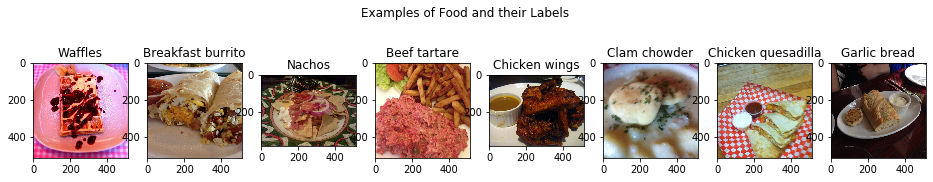

In [20]:
# Visualises the data by creating a plot of 8 random food images attached to their Labels
display_num = 8
r_choices = np.random.choice(num_train_examples, display_num) # Get 8 random numbers from num_train_examples

# Plot with figsize (16,3), 1 row, 8 columns
plt.figure(figsize=(16, 3))
for i in range(0, display_num, 1):
    img_num = r_choices[i]
    plt.subplot(1, 8, i+1)
    plt.imshow(mpimg.imread(Train_Img_Filepaths[img_num]))
    plt.title(Labels_Classes_Mapping['Labels'][Train_Labels[img_num]])
    
plt.suptitle("Examples of Food and their Labels")
plt.show()

### Setup Parameters

In [21]:
# Model Training Parameters
img_shape = (64, 64, 3) # Standardize input shape of image
batch_size = 10 # batch size
epochs = 13 # number of epochs the model will train for

- **Image Shape** 
  * With greater image resolution (increased image shape) performance improves
  * Localisation is more precise and less loss of information during encoding can be attained
  * The model can also be deeper
  * Although the trade off is a considerable increase in training time.
- **Batch Size**
  * Determining the best batch size is tricky 
  * A large batch size is computationally expensive and depending on hardware it may be too much so
  * Oppositely reducing batch size lessens computation cost but can dramatically increase training times
  * Personnally I tried a quite a few different settings and for reasons I havent figured out yet, with low batch sizes the accuracy of the model intially drops substantially and then slowly increases.
  * Whereas with high batch sizes the accuracy of the model initially shoots up for early stages of the epoch and then more often than not decreases slowly...
- **Epochs**
  * A few tests were run with one epoch in order to compare different settings (these notebooks can be found in the 'Test Models and Scripts' folder on GitHub)
  * After testing, number of epochs was increased so that more training data could be fed through the model
- **Settings Used**
  * The hardware used is a Mac OSX laptop, and thus not very substantial, being restricted to a measly CPU
  * Project time constraints was also a bit of an issue
  * As a result the Image Shape and number of Epochs had to be kept small to avoid absurd training times
  * A Batch size of 32 was chosen to fit an initial model with the unaugmented training data in 1 epoch
  * Further training was commenced with a batch size of 42, higher batch sizes seemed to work better, in addition to the fact that *42 is the answer to life, the universe and everything!*
  

## Building a Input Data Pipeline with Augmentation Functions

It has been proven that models trained on larger datasets peform better, and thus the function of augmented data is to increase the amount of training data. This is done by applying slight transformations to the original data so that the values inputed into the model differ, from one piece of augmented data to the next stemming from the same original. By this technique, the model can gain a great increase of training data while never seeing the exact same input.

### Processing Pathnames

In [22]:
# Defines function that processes the image filepath returning a decoded image with 3 depth channels for RGB colours
def _process_pathnames(img_filepath):
    img_str = tf.read_file(img_filepath)
    img = tf.image.decode_jpeg(img_str, channels=3)
    return img

### Shifting the Image

In [23]:
# Defines function that performs a translation shift height or width ways 
# so that the individual pixel positions of the output image differ from the original input image
def shift_img(output_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], 
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([], 
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
     
        output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
        
    return output_img

### Flipping the Image

In [24]:
# Defines function that performs a left/right flip on the input image
# again so that there is variation in the pixel position compared with the original
def flip_img(horizontal_flip, tr_img):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img = tf.cond(tf.less(flip_prob, 0.5), 
                         lambda: (tf.image.flip_left_right(tr_img)), 
                         lambda: (tr_img))
    return tr_img

### Assembling Transformations in Augment Function

In [25]:
# Defines function that performs all of the data augmenting functions on input image
def _augment(img,
             resize=None,  # Resize the image to some size e.g. [64, 64]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left/right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
    if resize is not None:
    # Resize images
        img = tf.image.resize_images(img, resize)
  
    if hue_delta:
    # Adjust hue of image
        img = tf.image.random_hue(img, hue_delta)
  
    img = flip_img(horizontal_flip, img) # Left/right flip
    img = shift_img(img, width_shift_range, height_shift_range) # Width/height shift
    img = tf.to_float(img) * scale # Adjust range of pixel values (scale = 1 / 255 so pixel values are in the range of 0 and 1)
    return img

### Assembling all Preproccessing Mechanisms into one Function

In [26]:
# Defines function that embodies all of the preprocessing functions that need to be applied to input data
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
    num_x = len(filenames)
    
    # Create a tf.data.Dataset from the filenames
    img_dataset = tf.data.Dataset.from_tensor_slices(filenames)
    
    # Map our preprocessing functions to every element in our dataset,
    # taking advantage of multithreading
    img_dataset = img_dataset.map(_process_pathnames, num_parallel_calls=threads)
    img_dataset = img_dataset.map(preproc_fn, num_parallel_calls=threads)
    
    # Create a tf.data.Dataset from labels 
    # (using tf.cast if they are integers)
    label_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int32))
    
    # Creates a dataset joining (ziping) together the image and label datasets
    dataset = tf.data.Dataset.zip((img_dataset, label_dataset))
    
    # Shuffle the data
    if shuffle:
        dataset = dataset.shuffle(num_x)
  
    # It's necessary to repeat our data for all epochs (but with different augmentations)
    # Repeats dataset indefinetely 
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

### Setup Configurations for Creating Datasets

In [27]:
# Custom training proprocessing augmentation settings
train_config = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
train_preprocessing_fn = functools.partial(_augment, **train_config)

In [28]:
# Custom validation/test proprocessing augmentation settings
# No need to augment the images for validation/test set because
# the model does not alter its parameters due to them
# They are only there for reference and evaluation of the model
valid_config = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
valid_preprocessing_fn = functools.partial(_augment, **valid_config)

### Creating Datasets

In [29]:
# Create training/validation/test datasets using the get_baseline_dataset function
# with training or validation preprocessing functions
# Additionally, one hot encoded vector labels ('x_label_cat') can be used here
# in conjunction with the 'categorical_crossentropy' loss function in the model
# or the integer based labels ('x_Labels') can be used in conjunction with
# the 'spare_categorical_crossentropy' loss function in the model
train_ds = get_baseline_dataset(Train_Img_Filepaths, 
                                train_label_cat,
                                preproc_fn=train_preprocessing_fn,
                                batch_size=batch_size)
valid_ds = get_baseline_dataset(Valid_Img_Filepaths, 
                                valid_label_cat,
                                preproc_fn=valid_preprocessing_fn,
                                batch_size=batch_size)
test_ds = get_baseline_dataset(Test_Img_Filepaths, 
                                test_label_cat,
                                preproc_fn=valid_preprocessing_fn,
                                batch_size=batch_size)
# Print created dataset to show shapes and types
print(train_ds)
print(valid_ds)
print(test_ds)

W0706 22:49:58.390718 4557923776 deprecation.py:323] From <ipython-input-25-30d9b9abd103>:19: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


<DatasetV1Adapter shapes: ((?, 64, 64, 3), (?, 101)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?, 64, 64, 3), (?, 101)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?, 64, 64, 3), (?, 101)), types: (tf.float32, tf.int32)>


### Visualising Data Augmentation

W0706 22:49:59.692714 4557923776 deprecation.py:323] From <ipython-input-30-f6bc529eaefb>:9: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Data Augmentation Round 1


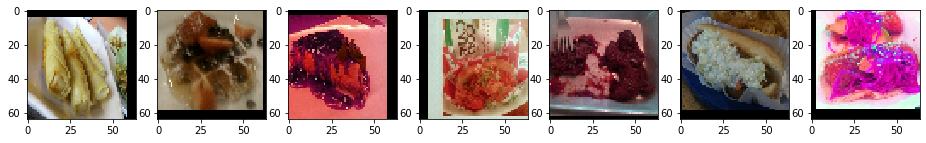

Data Augmentation Round 2


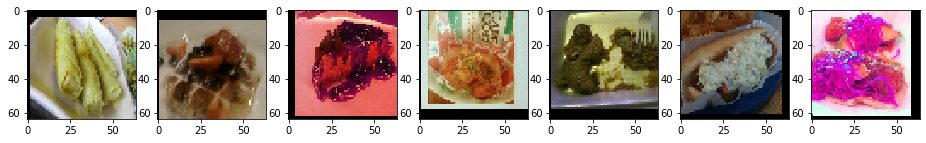

Data Augmentation Round 3


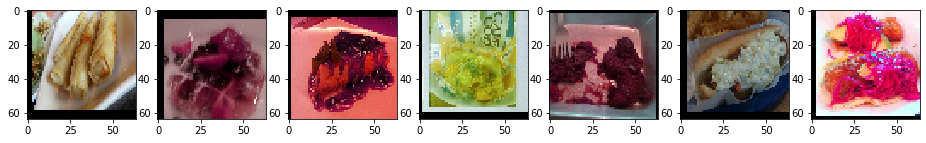

In [30]:
# Creates a temporary dataset using the training data and same method as before 
temp_ds = get_baseline_dataset(Train_Img_Filepaths, 
                               train_label_cat,
                               preproc_fn=train_preprocessing_fn,
                               batch_size=7,
                               shuffle=False)
# Examines some of these augmented images
# Create one shot iterator to return a batch of examples
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# For loop that creates 3 plots of the same images with 3 different rounds of data augmentation
for i in range(0,3):
    print('Data Augmentation Round '+str(i+1))
    with tf.Session() as sess: # Creates a tf.session that holds the values of intermediate results and variables
        # Runs next element in our graph to produce a batch of images
        batch_of_imgs, label = sess.run(next_element)
    
        # Designates the plot figure size as (16, 8)
        plt.figure(figsize=(16, 8))
        
        # For loop to plot each image from the batch of 7
        for a in range(0,7):
            img = batch_of_imgs[a]
            plt.subplot(1, 7, a+1)
            plt.imshow(img)
        
        plt.show()

## Building Model

- **Initial Model**
  * (Refer to 'Test Models and Scripts' folder on GitHub for notebooks related to the intial model creation --------- **Description of process follows**)
  * The initial model was a ResNet50 loaded from the keras models database
  * The Architecture of the model was loaded without alteration, but it was found that the original input shape of (224, 224, 3) was much too large for processing on a Mac OSX CPU
  * Thus the 'include_top' argument was stated as 'false' and a new input layer of shape (64, 64, 3) was added to the ResNet50 function argument
  * Since the original output of ResNet50 is for 1000 labels, a global average pooling 2D layer was added in as an argument to the ResNet50 function before the model was loaded
  * After loading, a fully connected dense layer of 101 nodes (for 101 classes) was manually added to the output of the customised ResNet50 model, this created a new model, based of the architecture of ResNet50 from keras, to fit the parameters of the Food101-Challenge
  * A couple tests were carried out too see the effectiveness of transfer learning by loading the weights of a ResNet50 pretrained on the ImageNet database
  * It was found that when evaluated without extra training a randomised model peformed just as well as the ImageNet model on unseen data of 101 classes, but after an epoch of training on the training data, the ImageNet model outpeformed the randomised model by quite a margin
  * Thus the initial model was loaded with ImageNet weights for further implementation
  * It was also discovered that during the first round (epoch) of training the model trained better with unaugmented data. Thus for the first epoch unaugmented training data was used
  * With all the outcomes of these settings test implemented in the model, a final comparison was made between using integer based labels ('sparse_categorical_crossentropy' loss function) and one hot encoded labels ('categorical_crossentropy' loss function)
  * It was observed (after one epoch) that using one hot encoded labels slightly increased accuracy with a little bit of overfitting, whereas using integer based labels accuracy caused a proportionally larger disparity between training and validation datasets in the form of underfitting. Thus a one hot encoded technique was established for further training.
  * LASTLY, it is worth mentioning that all of these tests were done with a single epoch/training round and so may be fairly unreliable, nonetheless it is better than nothing...

### Loading and Defining

In [31]:
# Load pretrained model from .h5 file
# Loads Architecture, weights, training config, optimisers... EVERYTHING from before

# Model includes customised ResNet50 initialised with ImageNet weights, 
# trained with unaugmented training data for one epoch,
# uses One Hot encoded labels and 'categorical_crossentropy' loss function
model = load_model(food101_dir+'models/15-6-4-5-SmallBatchModel.hdf5')

W0706 22:50:15.185297 4557923776 deprecation.py:506] From /Users/tombutterfield/.virtualenvs/food101env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0706 22:50:15.187041 4557923776 deprecation.py:506] From /Users/tombutterfield/.virtualenvs/food101env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0706 22:50:15.194935 4557923776 deprecation.py:506] From /Users/tombutterfield/.virtualenvs/food101env/lib/python3.6/site-packages/tensorflow/python/ops/init_o

In [32]:
evaluation = model.evaluate(test_ds, steps=int(np.ceil(num_test_examples / float(batch_size))))

2525/2525 [==============================] - 223s 88ms/step - loss: 2.6492 - acc: 0.3929


In [33]:
evaluation = model.evaluate(train_ds, steps=int(np.ceil(num_test_examples / float(batch_size))))

2525/2525 [==============================] - 284s 112ms/step - loss: 2.2716 - acc: 0.4403


In [34]:
evaluation = model.evaluate(valid_ds, steps=int(np.ceil(num_test_examples / float(batch_size))))

2525/2525 [==============================] - 245s 97ms/step - loss: 2.9362 - acc: 0.3542


### Training and Saving

In [35]:
cus = str(epochs)+'-2-6-4-5-SmallBatchModel.hdf5' # File name for the save model file path
save_model_path = food101_dir+'models/'+cus # Save model full file path

# Creates a callback variable that saves the full model after each epoch
# Only saves the best model based on validation loss (does not overwrite a better model for earlier epochs)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)

In [36]:
# Fits the model to the training dataset
# Number of steps per epoch determined by num_train_examples/batch_size
# Number of epochs determined earlier in epochs variable
# Uses valid_ds as the validation dataset (with no augmentations)
# Validation steps calculated as num_val_examples/batch_size
# Uses cp as a callback to save the model after each epoch
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=valid_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Epoch 1/13
6059/6060 [============================>.] - ETA: 0s - loss: 2.1796 - acc: 0.4388
Epoch 00001: val_loss improved from inf to 3.40859, saving model to /Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/models/13-2-6-4-5-SmallBatchModel.hdf5
6060/6060 [==============================] - 5414s 893ms/step - loss: 2.1795 - acc: 0.4388 - val_loss: 3.4086 - val_acc: 0.2686
Epoch 2/13
6059/6060 [============================>.] - ETA: 0s - loss: 2.1117 - acc: 0.4562
Epoch 00002: val_loss did not improve from 3.40859
6060/6060 [==============================] - 5969s 985ms/step - loss: 2.1118 - acc: 0.4562 - val_loss: 3.7240 - val_acc: 0.3275
Epoch 3/13
6059/6060 [============================>.] - ETA: 1s - loss: 2.0453 - acc: 0.4687
Epoch 00003: val_loss improved from 3.40859 to 3.27587, saving model to /Users/tombutterfield/Documents/GitHub/Food101-ML-Project/food-101/models/13-2-6-4-5-SmallBatchModel.hdf5
6060/6060 [==============================] - 6637s 1s/step - l

In [37]:
model.save(food101_dir+'models/AfterTrainCopy-13-2-6-4-5-SmallBatchModel.h5')

## Evaluating Model

#### *It took close to 10 hours to run just 4!!! epochs of training data for this model - 2.5 hours each epoch for batch size 10*

### Visualising Training Process

- A significant observation was that, using a batch size of 42, at the start of each epoch the accuracy seemed to shoot up a considerable amount only then to level off, and sometimes even decrease over the rest of the epoch

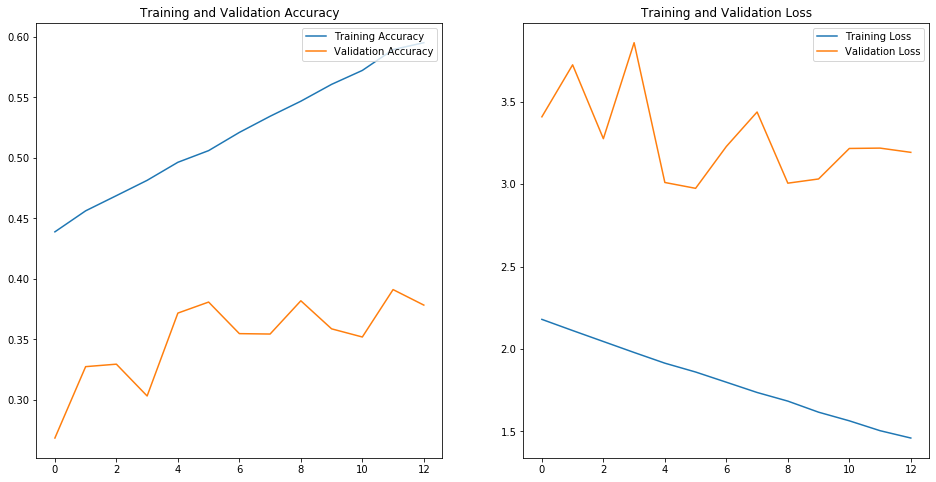

In [38]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

- Evaluation of the model saved at two different points can be seen in the next section... 

### Evaluating Actual Performance

- **Model 2**
  * The model being loaded here into 'model2' is the ResNet50 'model' saved after the 5th epoch in the training
  * The model save was not overridden after any later epoch because the validation loss did not improve

In [39]:
model2 = load_model(food101_dir+'models/15-6-4-5-SmallBatchModel.hdf5')
evaluation = model2.evaluate(test_ds, steps=int(np.ceil(num_test_examples / float(batch_size))))

2525/2525 [==============================] - 359s 142ms/step - loss: 2.6492 - acc: 0.3929


- **Model 3**
  * The model being loaded here into 'model3' is the ResNet50 'model' saved after the final epoch, at the end of training
  * Ignoring any monitors such as inter epoch changes to validation loss, unlike model 2

In [41]:
model3 = load_model(food101_dir+'models/AfterTrainCopy-13-2-6-4-5-SmallBatchModel.h5')
evaluation = model3.evaluate(test_ds, steps=int(np.ceil(num_test_examples / float(batch_size))))

2525/2525 [==============================] - 326s 129ms/step - loss: 2.9273 - acc: 0.4206


## Notes on Further Training

- Training will be continued with the insights of this round of 10 epochs
- The main things that will be changed with further training is the batch size (to test out batch sizes) and also the loss function
- The loss function will be changed to 'sparse_categorical_crossentropy' in addition to using integer based labels instead of one hot encoded
- The reason for this is that in the 1st epoch testing round, it was found the using integer based labels caused a fair bit of underfitting whereas the one hot encoded labels cause some overfitting
- After training for 10 epochs it is apparent there is significant overfitting, and although im not sure as too why, maybe changing the loss function will make a difference by balancing out the overfitting, with a hint of underfitting...

#### If there is someone reading this...----->
#### ----> I know the deadline has passed so that is why im writing this message! Having started the challenge a bit late, I am still working on the last bits, im currently trying to improve the models performance through more training (very time consuming, especially on a mac CPU) and add evaluation sections to the notebook. 
#### I understand if you leave this notebook as it is and dont look at it again, as I am late in finishing, but if you wanted to assess another and then come back to it in a jiffy, there will be a better project! Nonetheless I will continue working to improve it! But right now I need to sleep...Best Regards

#### If you have read this and there is a New and Improved notebook version available, skip straight to the build/train/evaluate model stage to see newer results, as the rest of the notebook is more or less identical